In this example we use the latitude and longitude points generated from the attributes determine across all NetCDF files.

In [1]:
import numpy as np
import xarray as xr

In [2]:
max_xorig = -160.0 # <1>
max_xcell = 0.10000000149011612 # <2>
max_yorig = 32.0 # <3>
max_ycell = 0.10000000149011612 # <4>

big_lon = np.linspace(max_xorig, max_xorig + max_xcell * (1081 - 1), 1081) # <5>
big_lat = np.linspace(max_yorig, max_yorig + max_ycell * (381 - 1), 381) # <6>

big_lon_pts, big_lat_pts = np.meshgrid(big_lon, big_lat) # <7>
big_tups = np.array([tup for tup in zip(big_lon_pts.flatten(), big_lat_pts.flatten())]) # <8>

sml_ds = xr.open_dataset("dispersion_20210304.nc") # <9>
sml_lon = np.linspace(sml_ds.XORIG, sml_ds.XORIG + sml_ds.XCELL * (sml_ds.NCOLS - 1), sml_ds.NCOLS) # <10>
sml_lat = np.linspace(sml_ds.YORIG, sml_ds.YORIG + sml_ds.YCELL * (sml_ds.NROWS - 1), sml_ds.NROWS) # <11>

sml_lon_pts, sml_lat_pts = np.meshgrid(sml_lon, sml_lat) # <12>
sml_tups = np.array([tup for tup in zip(sml_lon_pts.flatten(), sml_lat_pts.flatten())]) # <13>

1. Define the maximum x-origin coordinate.
2. Define the maximum x-cell size.
3. Define the maximum y-origin coordinate.
4. Define the maximum y-cell size.
5. Create an array for the large longitude grid.
6. Create an array for the large latitude grid.
7. Create a meshgrid of points using the large longitude and latitude arrays.
8. Create a flattened array of tuples representing the large grid points.
9. Open the small dataset using xarray.
10. Create an array for the small longitude grid.
11. Create an array for the small latitude grid.
12. Create a meshgrid of points using the small longitude and latitude arrays.
13. Create a flattened array of tuples representing the small grid points.

In [3]:
print(f'Using the large grid, we have {np.shape(big_tups)[0]} lat/lon points to sample on.')
print(f'Using the small grid, we have {np.shape(sml_tups)[0]} lat/lon points to sample from.')

Using the large grid, we have 411861 lat/lon points to sample on.
Using the small grid, we have 396621 lat/lon points to sample from.


Let's get the data at timestep 0 inside `dispersion_20210304.nc`, which uses a grid of size 381×1041.

In [4]:
timestep = 0

vals = np.squeeze(sml_ds['PM25'].values)

print(f'The shape of the PM25 array at timestep {timestep} is {np.shape(vals[timestep])}')

The shape of the PM25 array at timestep 0 is (381, 1041)


We use the following parameters with [`griddata`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) to resample `vals`:

`griddata(points, values, xi, method='cubic', fill_value)`

- `points`: Data point coordinates.
- `values`: Data values.
- `xi`: Points at which to interpolate data.
- `method`: cubic, 2D: Return the value determined from a piecewise cubic, continuously differentiable (C1), and approximately curvature-minimizing polynomial surface.
- `fill_value`: Value used to fill in for requested points outside of the convex hull of the input points.

In [5]:
from scipy.interpolate import griddata

points = sml_tups # <1>
values = vals[timestep].flatten() # <2>
xi = big_tups # <3>
method = 'cubic' # <4>
fill_value = 0 # <5>

arr = griddata(points, values, xi, method, fill_value) # <6>

print(f'We have interpolated 381×1081 = {np.shape(arr)[0]} points.') # <7>

We have interpolated 381×1081 = 411861 points.


1. The points we want to sample from.
2. The values for the grid we want to sample from, flattened into a 1D array.
3. The points we want to sample to.
4. The interpolation method used ('cubic' in this case).
5. The fill value to use (0 instead of NaN).
6. Perform the interpolation.
7. Print the number of points interpolated.

Notice that we have interpolated values that are negative.

In [6]:
print(f'The minimum PM25 value in our interpolated values is {np.min(arr)}')

The minimum PM25 value in our interpolated values is -0.0004518490243624799


We change values less than our specified threshold to 0. We then reshape the values to be 381×1081 and make all the values of type float32, as this number type is used in the original NetCDF file for PM25 values.

In [7]:
arr[arr < 1e-15] = 0 # <1>

arr = arr.reshape((len(big_lat), len(big_lon))) # <2>

arr = arr.astype(np.float32) # <3>

print(f'The shape of the resampled PM25 array at timestep {timestep} is {np.shape(arr)}') # <4>

The shape of the resampled PM25 array at timestep 0 is (381, 1081)


1. Any values that are less than a given threshold, make it 0.
2. Reshape the result to match the new grid shape.
3. Cast number to float32.
4. Print the shape of the resampled PM25 array at the given timestep.

Now we can visualize the resampled values:

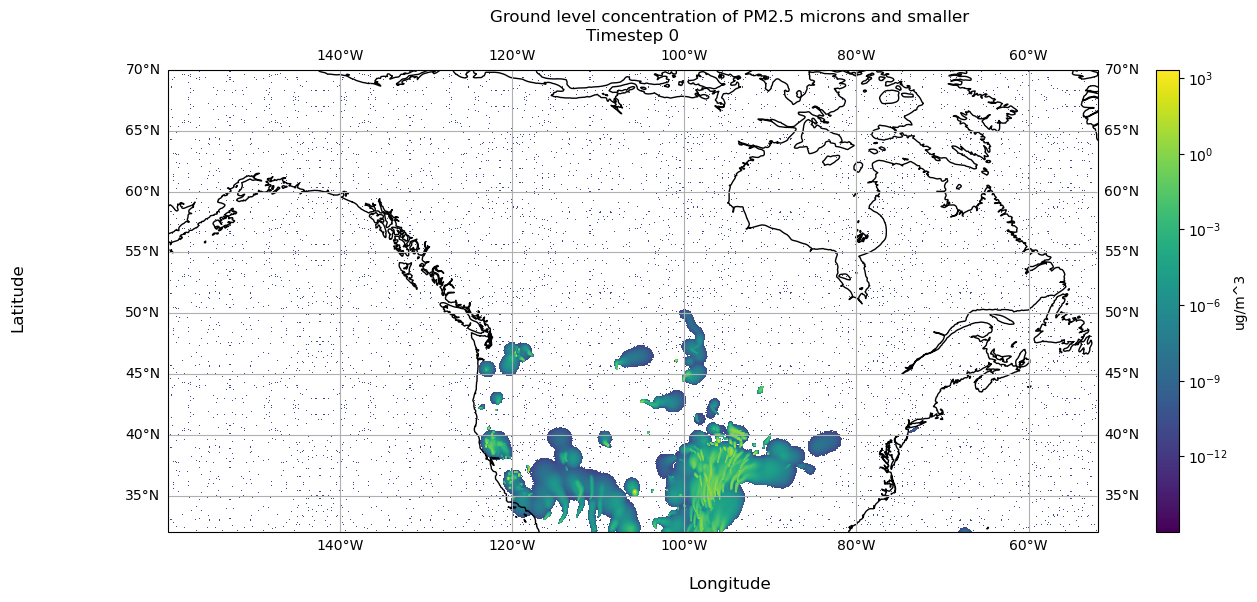

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

my_fig, my_plt = plt.subplots(figsize=(15, 6), subplot_kw=dict(projection=ccrs.PlateCarree())) # <1>

my_norm = "log" # <2>
my_extent = [np.min(big_lon), np.max(big_lon), np.min(big_lat), np.max(big_lat)] # <3>
my_aspect = 'auto' # <4>
my_origin = 'lower' # <5>
my_cmap = 'viridis' # <6>

plot = my_plt.imshow(arr, norm=my_norm, extent=my_extent, 
          aspect=my_aspect, origin=my_origin, cmap=my_cmap) # <7>

my_plt.coastlines() # <8>

my_plt.gridlines(draw_labels=True) # <9>

my_fig.colorbar(plot, location='right', label='ug/m^3') # <10>

my_fig.supxlabel('Longitude') # <11>
my_fig.supylabel('Latitude') # <12>

my_fig.suptitle('Ground level concentration of PM2.5 microns and smaller') # <13>

my_plt.set_title(f'Timestep {timestep}') # <14>

plt.show() # <15>

1. Initialize a figure and plot, so we can customize figure and plot of data.
2. Color PM25 values on a log scale, since values are small.
3. This will number our x and y axes based on the longitude latitude range.
4. Ensure the aspect ratio of our plot fits all data, matplotlib can do this automatically.
5. Tell matplotlib our origin is the lower-left corner.
6. Select a colormap for our plot and the color bar on the right.
7. Create our plot using imshow.
8. Draw coastlines.
9. Draw latitude longitude lines.
10. Add a colorbar to our figure, based on the plot we just made above.
11. Set x axis label on our ax.
12. Set y axis label on our ax.
13. Set title of our figure.
14. Set title of our plot as the timestamp of our data.
15. Show the resulting visualization.